In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=13a4e83b1f49e0531a41252a6924abc121797d7e9410d64496028b0001e9b490
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


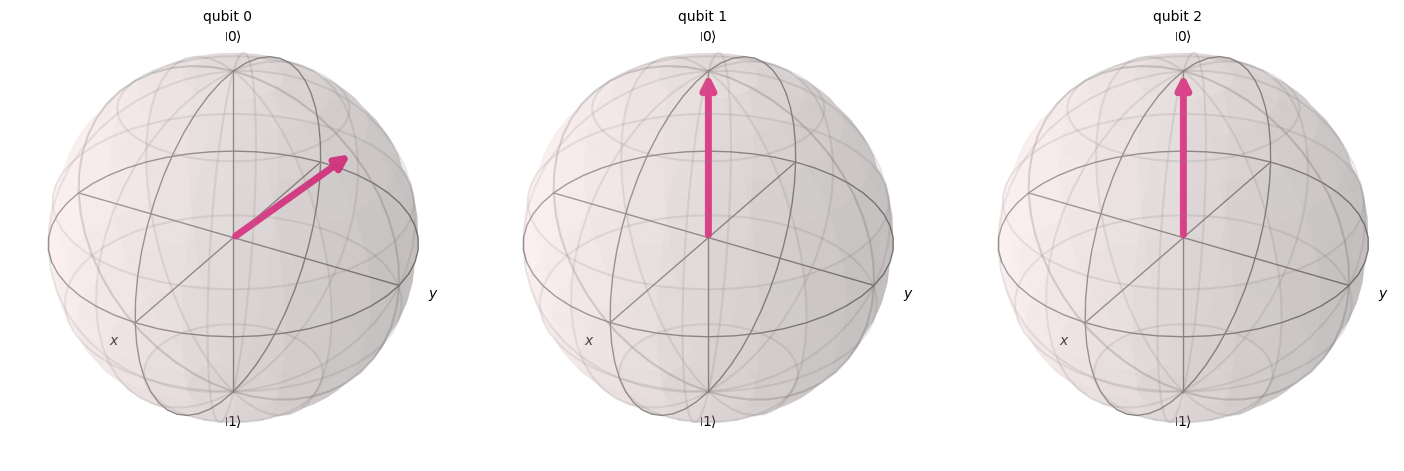

Fidelity = 1.000000


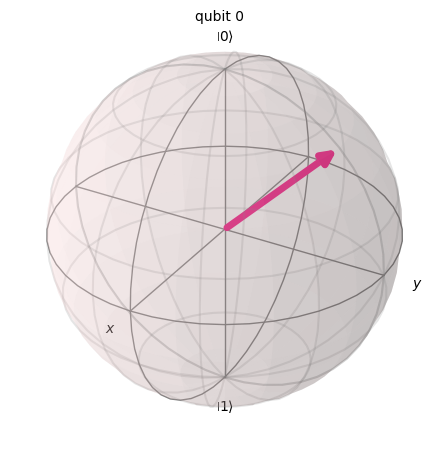

In [4]:
# Task 1 — Custom State Teleportation
# ============================================
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np

# Parameters – try different values like (np.pi/4, np.pi/2)
theta, phi = np.pi/4, np.pi/2

qc = QuantumCircuit(3)

# Prepare custom state |ψ>
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv_initial))

# Bell pair creation
qc.h(1)
qc.cx(1, 2)

# Bell measurement
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# Extract Bob's state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Compare fidelity
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2

print(f"Fidelity = {fidelity:.6f}")
display(plot_bloch_multivector(Statevector(bob_state)))


Bloch sphere of Bob’s final qubit after conditional corrections:


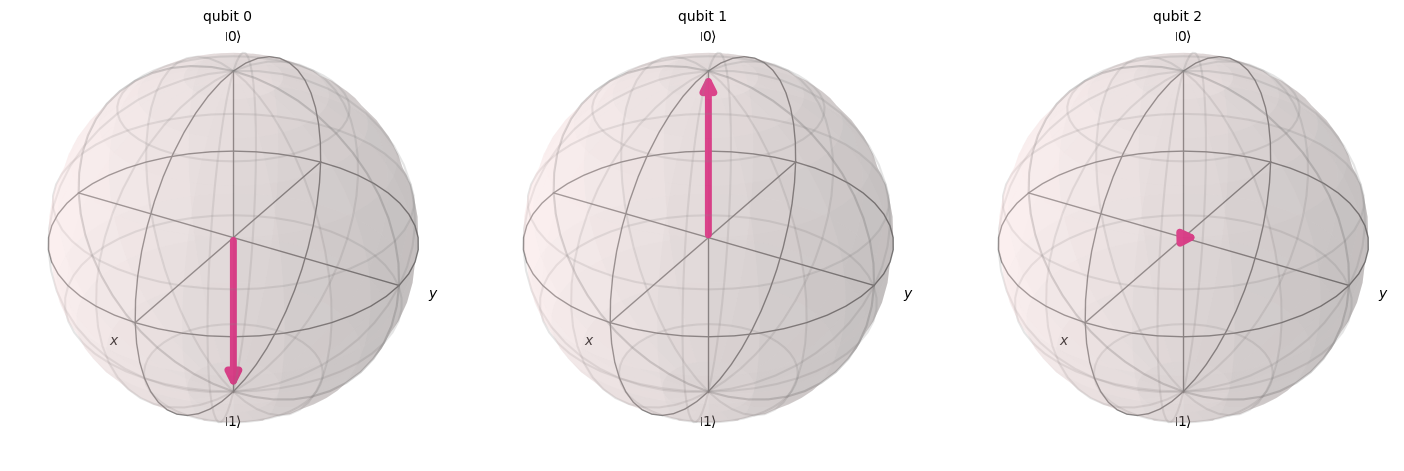

In [11]:
# Task 2 — Teleportation with measurement & classical correction
# ============================================
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import numpy as np

# Initialize 3 qubits + 2 classical bits
qc = QuantumCircuit(3, 2)

# Prepare initial state |ψ> on qubit 0
theta, phi = np.pi/3, np.pi/5
qc.ry(theta, 0)
qc.rz(phi, 0)

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell-state measurement on Alice’s side
qc.cx(0, 1)
qc.h(0)
qc.measure([0, 1], [0, 1])

# ✅ Conditional corrections using if_test() (modern Qiskit 2.x)
with qc.if_test((0, 1)):
    qc.x(2)
with qc.if_test((0, 2)):
    qc.z(2)
with qc.if_test((0, 3)):
    qc.x(2)
    qc.z(2)
    qc.save_statevector()

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

print("Bloch sphere of Bob’s final qubit after conditional corrections:")
display(plot_bloch_multivector(sv_final))


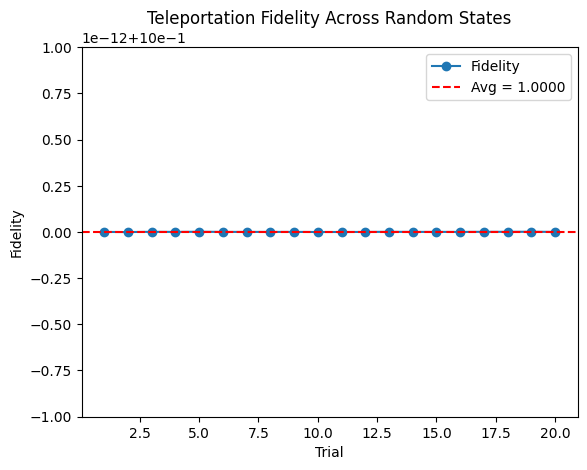

In [6]:
# Task 3 — Fidelity analysis for multiple random states
# ============================================
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np
import matplotlib.pyplot as plt

sim = AerSimulator()

def teleport_fidelity(theta, phi):
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    sv_initial = Statevector.from_instruction(qc)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)
    qc.save_statevector()
    compiled = transpile(qc, sim)
    sv_final = Statevector(sim.run(compiled).result().data(0)["statevector"])
    rho_bob = partial_trace(sv_final, [0, 1])
    rho_init = partial_trace(sv_initial, [1, 2])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]
    return np.abs(np.vdot(init_state, bob_state))**2

# Run for 20 random states
thetas = np.random.uniform(0, np.pi, 20)
phis = np.random.uniform(0, 2*np.pi, 20)
fidelities = [teleport_fidelity(t, p) for t, p in zip(thetas, phis)]

plt.plot(range(1, 21), fidelities, 'o-', label='Fidelity')
plt.axhline(np.mean(fidelities), color='r', linestyle='--', label=f'Avg = {np.mean(fidelities):.4f}')
plt.xlabel("Trial")
plt.ylabel("Fidelity")
plt.title("Teleportation Fidelity Across Random States")
plt.legend()
plt.show()

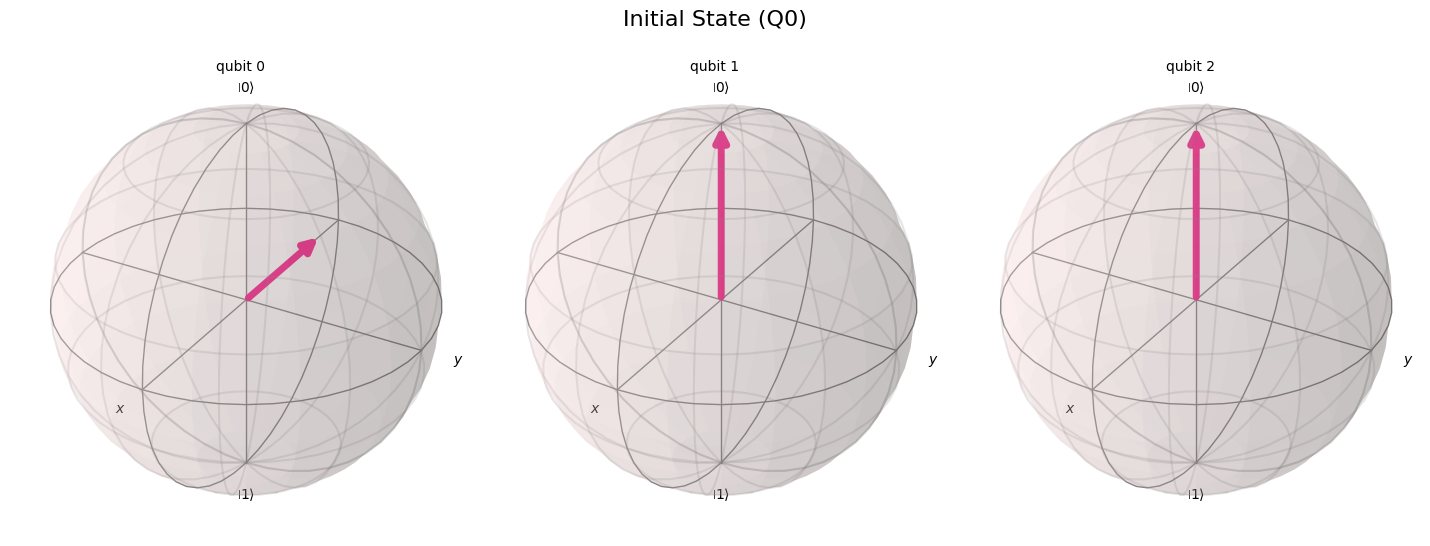

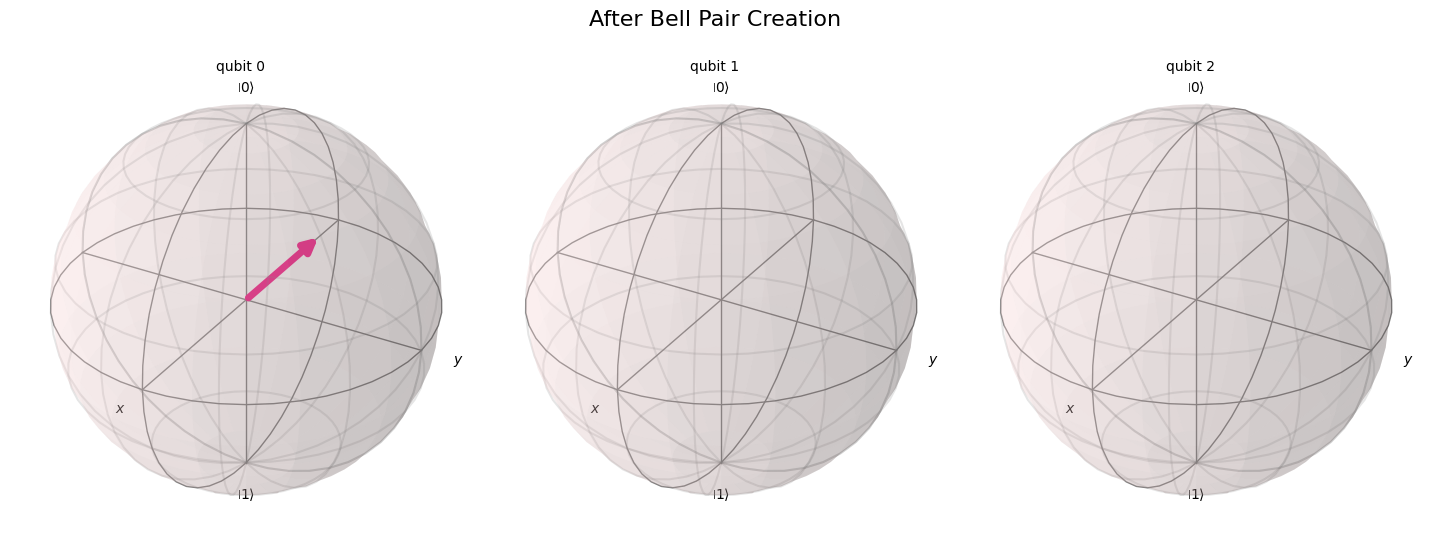

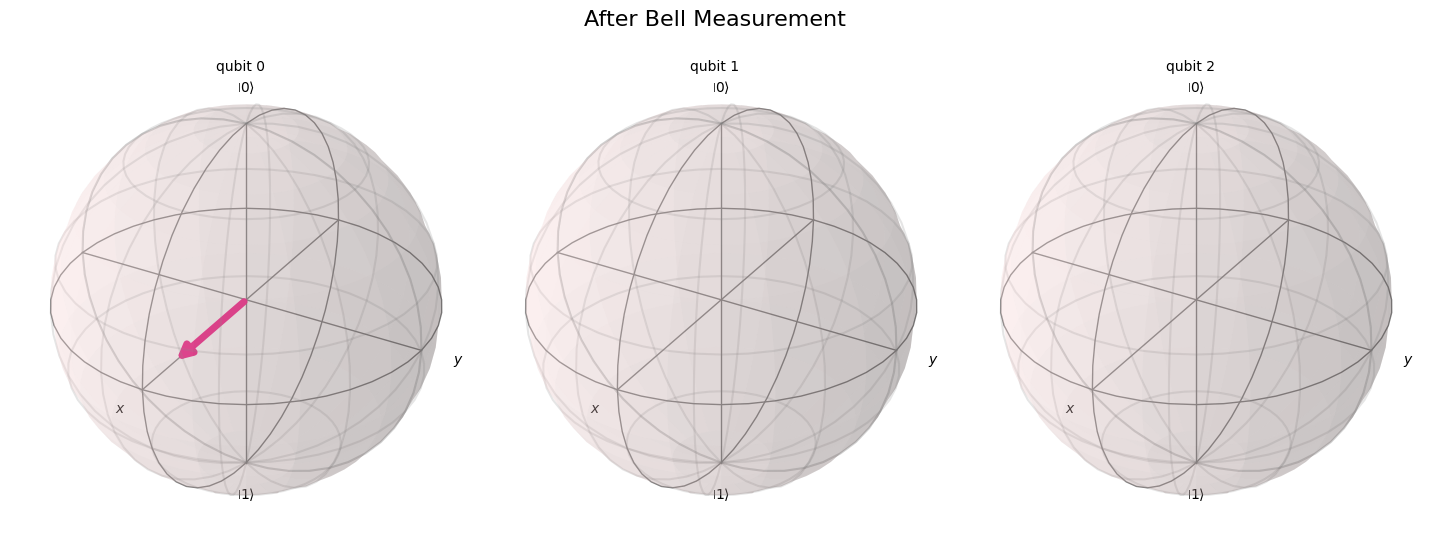

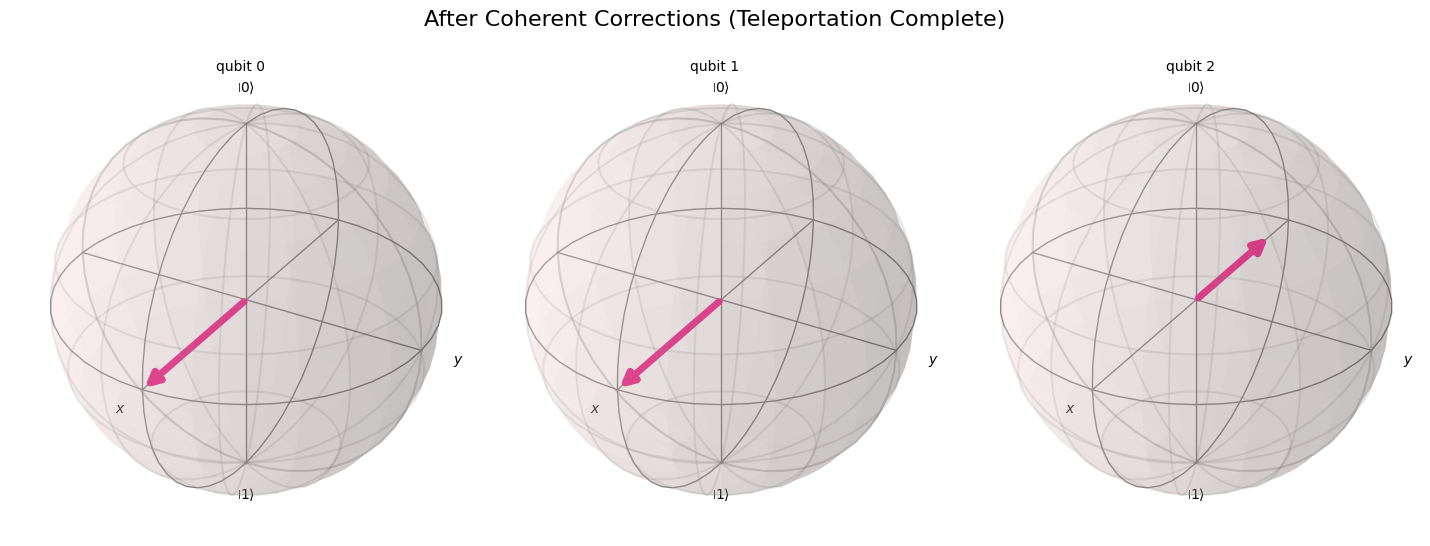

In [7]:
# Task 4 — Step-by-step visualization of teleportation
# ============================================
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np

qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/3
qc.ry(theta, 0)
qc.rz(phi, 0)

sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="Initial State (Q0)"))

qc.h(1)
qc.cx(1, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="After Bell Pair Creation"))

qc.cx(0, 1)
qc.h(0)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="After Bell Measurement"))

qc.cx(1, 2)
qc.cz(0, 2)
sv = Statevector.from_instruction(qc)
display(plot_bloch_multivector(sv, title="After Coherent Corrections (Teleportation Complete)"))


In [12]:
# Task 5 — Introduce noise and observe fidelity degradation
# ============================================
!pip install qiskit qiskit_aer pylatexenc -q

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector, partial_trace
import numpy as np

# Create a simple depolarizing noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 1), ['rz', 'ry', 'h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.02, 2), ['cx'])

# Use Aer simulator with noise
sim = AerSimulator(noise_model=noise_model)

# Prepare initial qubit
theta, phi = np.pi/4, np.pi/3
qc = QuantumCircuit(3)
qc.ry(theta, 0)
qc.rz(phi, 0)
sv_initial = Statevector.from_instruction(qc)

# Teleportation circuit (coherent)
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector()

compiled = transpile(qc, sim)
result = sim.run(compiled).result()
sv_final = Statevector(result.data(0)["statevector"])

# Compute fidelity
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]
fidelity = np.abs(np.vdot(init_state, bob_state))**2

print(f"Fidelity under noise = {fidelity:.6f}")

Fidelity under noise = 1.000000
